In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import keras.backend as kb
import tensorflow
from keras.utils.vis_utils import plot_model

from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
names = ['datetime', 'price', 'demand', 'sch_gen', 'semi_sch_gen', 'import', 'type']
df = pd.read_csv('./AEMO.csv', header=1, names=names, parse_dates=[0], infer_datetime_format=True, index_col=[0])
df.head()

,price,demand,sch_gen,semi_sch_gen,import,type
datetime,,,,,,
2021-08-31 05:45:00,46.20671,7310.94,6236.00057,447.10943,-612.39,ACTUAL
2021-08-31 05:50:00,61.00000,7462.29,6385.94521,444.06479,-616.45,ACTUAL
2021-08-31 05:55:00,64.39671,7492.96,6513.65054,444.05946,-522.74,ACTUAL
2021-08-31 06:00:00,66.03000,7644.78,6601.04363,442.29637,-588.15,ACTUAL
2021-08-31 06:05:00,55.00015,7703.97,6671.92424,434.85576,-584.02,ACTUAL


In [3]:
df.drop('type', 1, inplace=True)
df.shape

(575, 5)

<Figure size 720000x216 with 0 Axes>

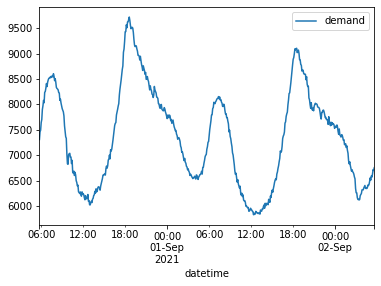

In [4]:
plt.figure(figsize=(10000, 3))
df[['demand']].plot()
plt.show()

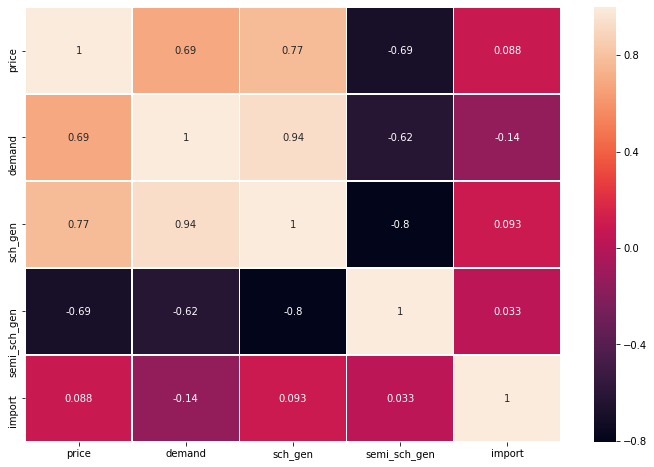

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True, linewidth=0.5)

In [6]:
def loss_function(y_actual, y_predicted):
    e = 0.5
    loss_value = e*kb.mean(kb.square(y_actual - y_predicted)) + (1-e)*kb.max(kb.square(y_actual - y_predicted))
    return loss_value

In [7]:
def LSTM_model(input_timestep, num_columns, units_first, drop_rate1, units_second, drop_rate2, output_timestep):
    model = keras.models.Sequential()

    model.add(keras.layers.LSTM(units_first, return_sequences=True))
    model.add(keras.layers.Dropout(drop_rate1))
    model.add(keras.layers.LSTM(units_second))
    model.add(keras.layers.Dropout(drop_rate2))
    model.add(keras.layers.Dense(output_timestep))
    
    optimizer = tensorflow.keras.optimizers.RMSprop()
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model

In [8]:
example = LSTM_model(50, 2, 50, 0.2, 100, 0.3, 1)
example.build(input_shape=(None,460, 5))
example.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 460, 50)           11200     
_________________________________________________________________
dropout (Dropout)            (None, 460, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 71,701
Trainable params: 71,701
Non-trainable params: 0
_________________________________________________________________


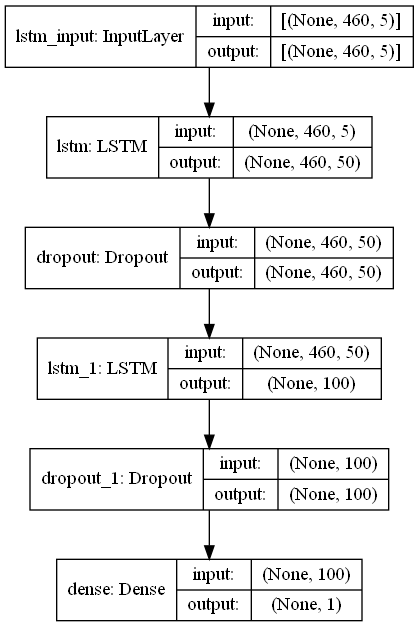

In [9]:
plot_model(example, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
def normalize(x):
    return (x - train_stats['min']) / (train_stats['max'] - train_stats['min'])

In [11]:
train_dataset = df.sample(frac=0.8,random_state=0)
print(train_dataset.shape)
test_dataset = df.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats.pop("demand")
train_stats = train_stats.transpose()

target = train_dataset['demand'].values
test_target = test_dataset['demand'].values

normed_train_data = normalize(train_dataset.drop('demand', axis=1))
normed_test_data = normalize(test_dataset.drop('demand', axis=1))

pca = PCA(.95)
pca.fit(normed_train_data)

pca_train = pca.transform(normed_train_data)
pca_test = pca.transform(normed_test_data)

X_train = pd.DataFrame(pca_train)
X_test = pd.DataFrame(pca_test)

(460, 5)


In [12]:
def BRSB_ensemble_train(training_data, lstm_base_learner, num_bagging, num_random, num_columns):
    T1 = num_bagging
    T2 = num_random
    
    bagging_members = []
    boosting_resample = []
    
    for t1 in range(T1):
        bootstrap_sample = resample(training_data, replace=True, n_samples=4, random_state=1)
        random_subspace_members = []
        
        for t2 in range(T2):
            random_subspace = bootstrap_sample.sample(n=num_columns,axis='columns')
            rs_feature_subspace = random_subspace.columns
            random_subspace = np.expand_dims(random_subspace, axis=2)
            test_dataset = X_test[rs_feature_subspace]
            
            model = LSTM_model(5, num_columns, 50, 0.2, 10, 0.3, 1)
            model.build(input_shape=random_subspace.shape)
            model.fit(random_subspace, target, epochs=10, validation_split = 0.2, verbose=1, batch_size=100)
            
            random_subspace_members.append((model, rs_feature_subspace))
            
        bagging_members.append(random_subspace_members)
    return bagging_members

In [13]:
model_network = BRSB_ensemble_train(X_train, LSTM_model, 3, 3, 1)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 56853972.0000 - val_loss: 65416896.0000
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 56853888.0000 - val_loss: 65416832.0000
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 56853824.0000 - val_loss: 65416772.0000
Epoch 4/10
1/1 [==============================] - 0s 48ms/step - loss: 56853760.0000 - val_loss: 65416708.0000
Epoch 5/10
1/1 [==============================] - 0s 50ms/step - loss: 56853664.0000 - val_loss: 65416644.0000
Epoch 6/10
1/1 [==============================] - 0s 52ms/step - loss: 56853680.0000 - val_loss: 65416596.0000
Epoch 7/10
1/1 [==============================] - 0s 47ms/step - loss: 56853580.0000 - val_loss: 65416540.0000
Epoch 8/10
1/1 [==============================] - 0s 48ms/step - loss: 56853524.0000 - val_loss: 65416496.0000
Epoch 9/10
1/1 [==============================] - 0s 51ms/step - loss: 56853524.0000 - val_loss: 65416448.0000
Epo

Epoch 5/10
1/1 [==============================] - 0s 44ms/step - loss: 56853748.0000 - val_loss: 65416732.0000
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 56853680.0000 - val_loss: 65416684.0000
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 56853700.0000 - val_loss: 65416644.0000
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 56853616.0000 - val_loss: 65416596.0000
Epoch 9/10
1/1 [==============================] - 0s 41ms/step - loss: 56853552.0000 - val_loss: 65416548.0000
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 56853508.0000 - val_loss: 65416512.0000
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 56853968.0000 - val_loss: 65416920.0000
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 56853868.0000 - val_loss: 65416840.0000
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 56853772.0000 - val_loss: 65416772.0000
Ep

In [14]:
def BRSB_ensemble_test(testing_data, test_labels, model_network):
    pruned_outputs = []
    for network in model_network:
        yhats = []
        for model in network:
            test_dataset = testing_data[model[1]]
            test_dataset = np.expand_dims(test_dataset, axis=2)
            predict = model[0].predict(test_dataset)
            yhats.append((predict, mean_squared_error(test_labels, predict)))
        pruned = [(a, b) for a, b in yhats if b >= 0.8]
        averaged = [sum(elem) / len(pruned) for elem in zip(*pruned)]
        pruned_outputs.append(averaged)
    weighted_avg = np.average( pruned_outputs[0], weights = pruned_outputs[1])

In [15]:
BRSB_ensemble_test(X_test, test_target, model_network)

C:\Users\Snehal Swadhin\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
